## Лабораторная 3: метод ближайших соседей (kNN)

В рамках этого занятия мы будем создавать модель для предсказания выживших пассажиров на "Титанике" (классическое учебное Kaggle [соревнование](https://www.kaggle.com/c/titanic)).

![Титаник](http://staff.mmcs.sfedu.ru/~sguda/MachineLearning/titanic.png)

## 1

Загрузите данные о погибших в катастрофе с "Титаником". Целевым признаком здесь является факт спасения пассажира. Посмотрите на данные.

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data.csv')
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Для простоты исключите пассажиров с неизвестным возрастом и заново перенумеруйте строки

*Функции, которые могут пригодиться при решении: `.dropna(subset=['Age']), .reset_index(drop=True)`*

In [4]:
data = data.dropna(subset=['Age'])
data = data.reset_index(drop=True)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
709,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
710,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
711,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
712,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 2

Постройте график рассеяния с возрастом в качестве оси абсцисс и ценой билета в качестве оси ординат. Отметьте красным — погибших, зеленым — спасшихся пассажиров. Постройте отдельно 2 графика: для женщин и для мужчин. 

Выполняется ли для данного множества гипотеза компактности?

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

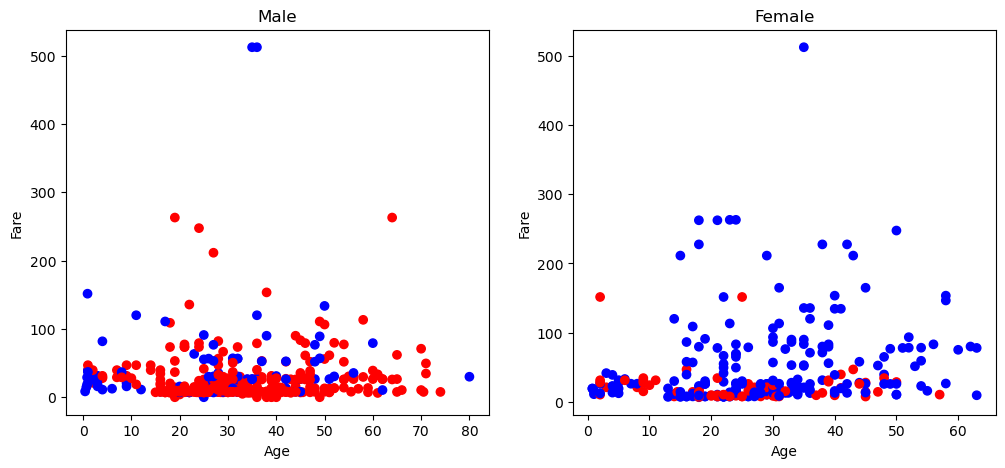

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

colors = {0: 'red', 1: 'blue'}

mask = data['Sex'] == 'male'
axs[0].scatter(data[mask]['Age'], data[mask]['Fare'], c=data[mask]['Survived'].apply(lambda x: colors[x]))
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Fare')
axs[0].set_title('Male')

mask = data['Sex'] == 'female'
axs[1].scatter(data[mask]['Age'], data[mask]['Fare'], c=data[mask]['Survived'].apply(lambda x: colors[x]))
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Fare')
axs[1].set_title('Female')

plt.show()


In [7]:
# место для кода

## 3 

Для построения модели нам понадобится метрика близости пассажиров. Запрограммируем функцию вычисления расстояния между пассажирами:

In [8]:
def distance(a,b):
    d = 0
    d += 2 * abs(a['Pclass'] - b['Pclass'])
    d += a['Sex'] != b['Sex']
    d += 0.25 * abs(a['Age'] - b['Age'])
    d += 2 * abs(a['SibSp'] - b['SibSp'])
    d += abs(a['Parch'] - b['Parch'])
    d += 0.25 * abs(a['Fare'] - b['Fare'])
    d += a['Embarked'] != b['Embarked']
    return d

Метод `KNeighborsClassifier` из библиотеки `sklearn` излишне требователен к типам данных. Запрограммируем метод `k` ближайших соседей вручную:

In [9]:
import numpy as np
import tqdm

In [10]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

Запустите предсказание для всех пассажиров судна и, используя LOO-контроль ошибки оцените качество классификации:

In [11]:
accuracy = 0
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    accuracy += row['Survived'] == myKNeighborsClassifier(data, 5, idx)
print(accuracy/data.shape[0])

100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [02:50<00:00,  4.19it/s]

0.7843137254901961


Подберите слагаемые в метрике, их веса и количество соседей так, чтобы качество классификации было максимальным. 

Если функция на `python` работает долго, воспользуйтесь ее аналогом на 
С++:  `KNeighborsClassifier.cpp.` 

Компиляция на Linux выполняется командой 

    g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier


Запуск: 

    ./KNeighborsClassifier
    
Построившему метрику с наилучшим качеством: +5 бонусных баллов.

## 4

Создайте копию функции `myKNeighborsClassifier` и измените ее так, чтобы она считала выступ объекта. Назовите ее `calcMargin`. 

Вычислите выступы для всех объектов и выведите информацию о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах). Объясните в комментариях полученные данные.

In [14]:
def calcMargin(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    margin = 0
    for i in range(K):
        if dists[i][1] == 1:
            margin += 1
        else:
            margin -= 1
    return margin


In [15]:
margins = []
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    margins.append(calcMargin(data, 5, idx))

data['Margin'] = margins

100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [02:56<00:00,  4.04it/s]


In [16]:
print(data.nlargest(5, 'Margin'))

print(data.nsmallest(5, 'Margin'))

    PassengerId  Survived  Pclass  \
7             9         1       3   
8            10         1       2   
33           44         1       2   
38           53         1       1   
43           59         1       2   

                                                 Name     Sex   Age  SibSp  \
7   Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
8                 Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   
33           Laroche, Miss. Simonne Marie Anne Andree  female   3.0      1   
38           Harper, Mrs. Henry Sleeper (Myna Haxtun)  female  49.0      1   
43                       West, Miss. Constance Mirium  female   5.0      1   

    Parch         Ticket     Fare Cabin Embarked  Margin  
7       2         347742  11.1333   NaN        S       5  
8       0         237736  30.0708   NaN        C       5  
33      2  SC/Paris 2123  41.5792   NaN        C       5  
38      0       PC 17572  76.7292   D33        C       5  
43      2    

Это легче всего сделать с помощью функции `np.argsort`, возвращающей индексы элементов в отсортированном ряду:

In [17]:
idx = np.argsort(margins)

In [18]:
print('Белые вороны (аномалии)')
data.loc[idx[:5],]

Белые вороны (аномалии)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Margin
605,759,0,3,"Theobald, Mr. Thomas Leonard",male,34.0,0,0,363294,8.0500,NaN,S,-5
584,735,0,2,"Troupiansky, Mr. Moses Aaron",male,23.0,0,0,233639,13.0000,NaN,S,-5
144,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0000,NaN,S,-5
583,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,NaN,S,-5
577,726,0,3,"Oreskovic, Mr. Luka",male,20.0,0,0,315094,8.6625,NaN,S,-5


In [19]:
print('Эталоны (характерные объекты)')
data.loc[idx[-5:],]

Эталоны (характерные объекты)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Margin
259,323,1,2,"Slayter, Miss. Hilda Mary",female,30.0,0,0,234818,12.35,NaN,Q,5
256,320,1,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",female,40.0,1,1,16966,134.50,E34,C,5
502,636,1,2,"Davis, Miss. Mary",female,28.0,0,0,237668,13.00,NaN,S,5
43,59,1,2,"West, Miss. Constance Mirium",female,5.0,1,2,C.A. 34651,27.75,NaN,S,5
356,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.00,NaN,S,5
